# Presets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astroquery.gaia import Gaia
from matplotlib.patches import Circle

In [2]:
# Load the exoplanet catalogue
exoplanet_catalogue = pd.read_csv('exoplanet_catalogue.csv')  # Exoplanet catalogue from local CSV
exoplanet_catalogue = exoplanet_catalogue.dropna(subset=['ra', 'dec'])  # Remove rows with missing RA/DEC

print(f"Exoplanet catalogue loaded with {len(exoplanet_catalogue)} entries.")

Exoplanet catalogue loaded with 7343 entries.


In [3]:
# num_exoplanets = 300
num_exoplanets = 30
subset_catalogue = exoplanet_catalogue.iloc[:num_exoplanets]
threshold = 10 * u.arcsec
gaia_results = []

for index, row in subset_catalogue.iterrows():
    ra = row['ra']
    dec = row['dec']
    exoplanet_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    
    # Query Gaia around the exoplanet's coordinates with the threshold
    query = Gaia.query_object_async(
        coordinate=exoplanet_coord, 
        radius=threshold
    )

    gaia_results.append(query)

gaia_stars = pd.concat([result.to_pandas() for result in gaia_results], ignore_index=True)

print(f"Processed {num_exoplanets} exoplanets.")
print(f"Found {len(gaia_stars)} stars in Gaia.")

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [7]:
# View the first rows of the Gaia results
# print(gaia_stars.head())

# View additional details about the available columns
# print(gaia_stars.info())

# Explore details of the processed exoplanets
# print(subset_catalogue.head())

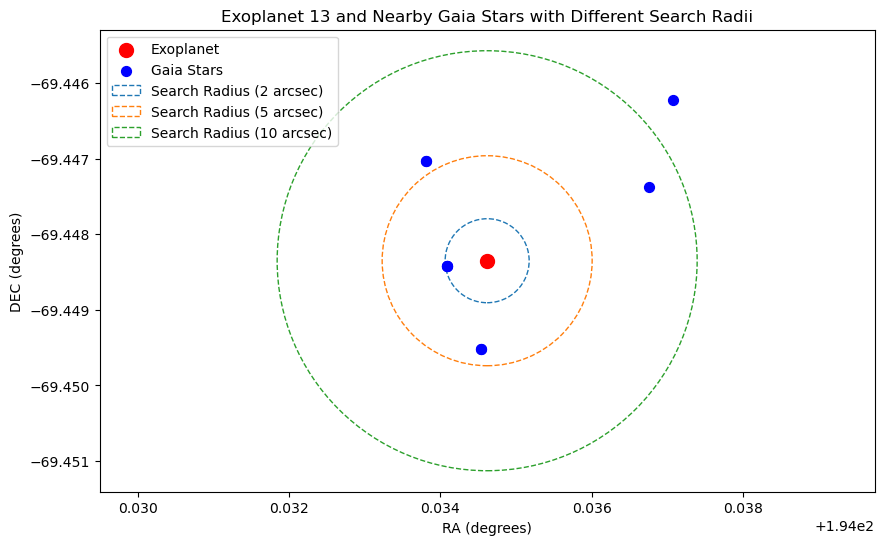

In [4]:
# exoplanet_index = 0
exoplanet_index = 12
exoplanet = subset_catalogue.iloc[exoplanet_index]
exoplanet_coord = SkyCoord(ra=exoplanet['ra'] * u.deg, dec=exoplanet['dec'] * u.deg, frame='icrs')

thresholds_arcsec = [2, 5, 10]  # search radii in arcseconds
thresholds_deg = [threshold * u.arcsec.to(u.deg) for threshold in thresholds_arcsec]

# Filter Gaia stars within the search radii
stars_in_radius = {}
for threshold_deg in thresholds_deg:
    stars_in_radius[threshold_deg] = gaia_stars[
        gaia_stars['ra'].between(exoplanet['ra'] - threshold_deg, exoplanet['ra'] + threshold_deg) &
        gaia_stars['dec'].between(exoplanet['dec'] - threshold_deg, exoplanet['dec'] + threshold_deg)
    ]

plt.figure(figsize=(10, 6))
plt.scatter(exoplanet['ra'], exoplanet['dec'], color='red', label='Exoplanet', s=100, zorder=5)

# Plot the matching Gaia stars in blue
first_iteration = True  # Flag to ensure 'Gaia Stars' label is added only once
for threshold_deg, threshold_arcsec in zip(thresholds_deg, thresholds_arcsec):
    stars = stars_in_radius[threshold_deg]
    # Plot all stars in blue
    if first_iteration:  # Only add the label in the first iteration
        plt.scatter(stars['ra'], stars['dec'], color='blue', alpha=1, s=50, label='Gaia Stars')
        first_iteration = False  # Disable label for subsequent iterations
    else:
        plt.scatter(stars['ra'], stars['dec'], color='blue', alpha=1, s=50)

    if threshold_arcsec == 2:
        circle_color = 'C0'  # Color for the 2 arcsec radius
    elif threshold_arcsec == 5:
        circle_color = 'C1'  # Color for the 5 arcsec radius
    else:
        circle_color = 'C2'  # Color for the 10 arcsec radius

    search_circle = Circle((exoplanet['ra'], exoplanet['dec']), radius=threshold_deg, color=circle_color, fill=False, linestyle='--', label=f'Search Radius ({threshold_arcsec} arcsec)')
    plt.gca().add_patch(search_circle)

plt.title(f'Exoplanet {exoplanet_index+1} and Nearby Gaia Stars with Different Search Radii')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.legend(loc='upper left')  # Legend outside the plot
# plt.grid()
plt.axis('equal')
# plt.ylim(3.09585, 3.0959)
# plt.xlim(30.039, 30.0395)
plt.show()

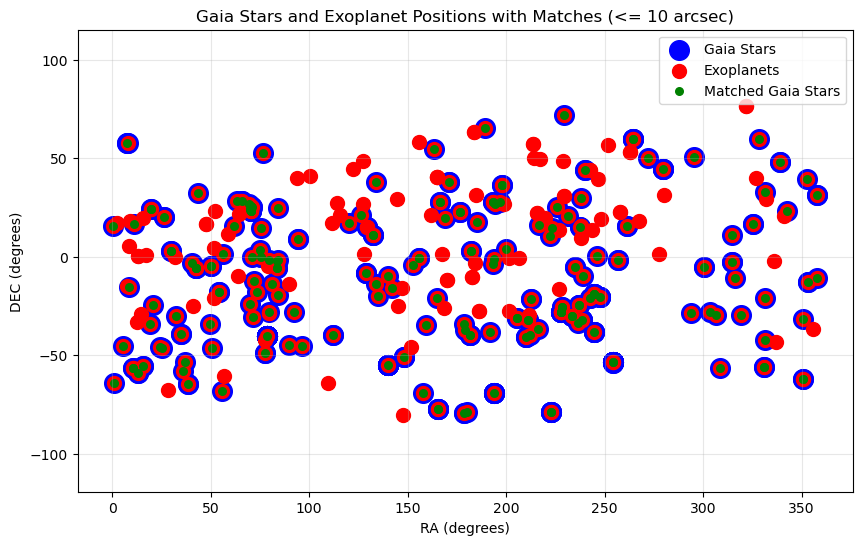

In [9]:
# Convert RA and DEC columns to SkyCoord objects with units
gaia_coords = SkyCoord(
    ra=gaia_stars['ra'].values * u.deg,
    dec=gaia_stars['dec'].values * u.deg,
    frame='icrs'
)

exoplanet_coords = SkyCoord(
    ra=subset_catalogue['ra'].values * u.deg,
    dec=subset_catalogue['dec'].values * u.deg,
    frame='icrs'
)

# Match coordinates between catalogs (Exoplanets and Gaia)
idx, sep2d, _ = match_coordinates_sky(exoplanet_coords, gaia_coords)

# Filter matches with separations less than or equal to 10 arcsec
match_mask = sep2d <= 10 * u.arcsec
matched_gaia_stars = gaia_stars.iloc[idx[match_mask]].reset_index(drop=True)
matched_exoplanets = subset_catalogue.iloc[match_mask].reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.scatter(gaia_stars['ra'], gaia_stars['dec'],color='blue', alpha=1, s=200, label='Gaia Stars')
plt.scatter(subset_catalogue['ra'], subset_catalogue['dec'],color='red', alpha=1, s=100, label='Exoplanets')
plt.scatter(matched_gaia_stars['ra'], matched_gaia_stars['dec'],color='green', alpha=1, s=30, label='Matched Gaia Stars')

plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.title('Gaia Stars and Exoplanet Positions with Matches (<= 10 arcsec)')
plt.legend()
plt.gca().set_aspect('equal', adjustable='datalim')
plt.grid(alpha=0.3)
plt.show()

In [5]:
# Filter exoplanets with valid (non-NaN) values in the V, I, J, H, K filters
required_filters = ['mag_v', 'mag_i', 'mag_j', 'mag_h', 'mag_k']

# Check if the required columns exist in the catalogue
missing_columns = [col for col in required_filters if col not in exoplanet_catalogue.columns]
if missing_columns:
    print(f"The following columns are missing in the catalogue: {missing_columns}")
else:
    # Filter exoplanets with values in all required filters
    exoplanets_with_magnitudes = exoplanet_catalogue.dropna(subset=required_filters)
    print(f"Out of {len(exoplanet_catalogue)} exoplanets in the catalogue, "
          f"{len(exoplanets_with_magnitudes)} have valid values for all filters: {', '.join(required_filters)}.")

Out of 7343 exoplanets in the catalogue, 420 have valid values for all filters: mag_v, mag_i, mag_j, mag_h, mag_k.


In [11]:
# Count non-null numeric values for each filter
filter_counts = {col: exoplanet_catalogue[col].apply(pd.to_numeric, errors='coerce').notna().sum() for col in required_filters}

for col, count in filter_counts.items():
    print(f"{col}: {count} exoplanets with numeric values.")

mag_v: 3451 exoplanets with numeric values.
mag_i: 584 exoplanets with numeric values.
mag_j: 3839 exoplanets with numeric values.
mag_h: 3820 exoplanets with numeric values.
mag_k: 3177 exoplanets with numeric values.


In [12]:
# Adjust pandas settings to display all rows
pd.set_option('display.max_rows', None)

# Count valid numeric values per column
column_valid_counts = exoplanet_catalogue.apply(lambda col: col.apply(pd.to_numeric, errors='coerce').notna().sum())

# Sort columns by the number of valid values
sorted_column_counts = column_valid_counts.sort_values(ascending=False)

# Display all columns sorted by the number of valid numeric values
print("Columns sorted by the number of valid numeric values (from highest to lowest):")
print(sorted_column_counts)

# Restore original settings to avoid displaying too many rows elsewhere in the code
pd.reset_option('display.max_rows')

Columns sorted by the number of valid numeric values (from highest to lowest):
ra                            7343
dec                           7343
discovered                    7334
star_distance                 6992
star_mass                     6118
orbital_period                6063
star_teff                     5861
star_radius                   5691
star_teff_error_min           5562
star_teff_error_max           5562
orbital_period_error_min      5317
orbital_period_error_max      5317
star_metallicity              5191
semi_major_axis               5059
star_radius_error_max         5055
star_radius_error_min         5055
star_distance_error_min       5015
star_distance_error_max       5015
radius                        4927
star_mass_error_min           4861
star_mass_error_max           4861
mass                          4385
radius_error_max              4343
radius_error_min              4343
star_metallicity_error_min    4319
star_metallicity_error_max    4319
mag_j      

To filter stars in the case of multiple matches, we can compare the values of the following parameters with those of the host star listed on exoplanet.eu. The challenge is that since we don't have a parameter available for all exoplanets in the catalog, we would need to filter incrementally using some of these parameters until we achieve the correct match for all possible exoplanets.

- star_mass  
- star_teff  
- star_radius  
- star_metallicity  

- mag_j  
- mag_h  
- mag_v  
- mag_k

Let's abandon this method since the planets on exoplanet.eu are already cross-matched with their host stars. We'll rely on this work and won't duplicate it. Instead, we'll attempt to cross-match the catalog with Gaia directly using the host star identifier. We can continue using Python and Astroquery, but let's explore whether TOPCAT or STILTS can help us achieve this faster and more efficiently.